# Установка и импорт библиотек

In [3]:
!pip install openpyxl
!pip install catboost
!pip install optuna
!pip install scikit-learn
!pip install seaborn

In [4]:
# Импорт библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool
import optuna
from optuna.samplers import TPESampler
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
# Загрузка файла
# Чтение данных
df = pd.read_csv('data/dataset.csv')

print(df['fire'].eq(0).sum())
print(df['fire'].eq(1).sum())

# Проверка
print(df.head())

2063
1029
       lat  temp  humidity  windspeed  precip  fire  month  ffmc  dmc    dc  \
0  60.9660  31.4      60.0       13.6     0.0     0      7  87.2  9.1  24.4   
1  60.9660  31.9      64.5       15.5     0.0     0      7  86.6  8.8  24.4   
2  60.9660  26.8      65.0       22.2     0.0     1      7  85.7  8.3  23.5   
3  60.9917  31.6      65.7       19.8     0.0     0      7  86.3  8.6  24.4   
4  60.9917  28.2      64.3       21.4     0.0     0      7  86.0  8.5  23.8   

   isi  bui  fwi  
0  5.7  9.4  6.0  
1  5.7  9.3  5.9  
2  7.1  8.8  7.1  
3  6.8  9.1  6.9  
4  7.1  9.0  7.2  


In [45]:
# Подготовка данных
df = pd.read_csv('data/dataset.csv')

# Удаляем незначимые признаки.
df.drop(["lat", "month", 'humidity'], axis=1, inplace=True)

# Конвертируем значения таргетной колонки в числовые признаки
# df["Classes"] = df["Classes"].map({"not fire": 0, "fire": 1})

# Разделение на тренировочную и тестовую выборки
X = df.drop('fire', axis=1)
y = df["fire"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


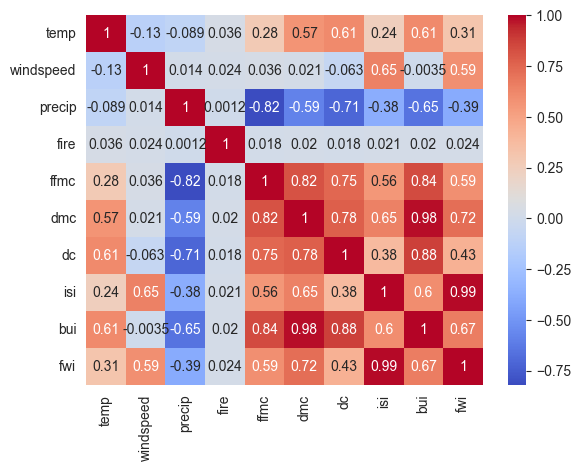

In [46]:
# корреляции

corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [50]:
# Создание Pool для CatBoost
train_pool = Pool(
    X_train,
    y_train,
)

test_pool = Pool(
    X_test,
    y_test,
)

# Функция для оптимизации гиперпараметров с Optuna
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        # 'auto_class_weights': 'Balanced',
        'scale_pos_weight': trial.suggest_float("scale_pos_weight", 0.1, 10.0),
        'verbose': False,
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'early_stopping_rounds': 50,
    }

    scores = []
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    for train_idx, valid_idx in cv.split(X_train, y_train):
        x_tr, x_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = CatBoostClassifier(**params)
        model.fit(
            x_tr, y_tr,
            eval_set=(x_val, y_val),
            use_best_model=True,
            verbose=0
        )

        preds = model.predict(x_val)
        scores.append(f1_score(y_val, preds))

    return np.mean(scores)

# Отключаем лишние логи Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Оптимизация гиперпараметров
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
)
study.optimize(objective, n_trials=30, show_progress_bar=True)

Best trial: 11. Best value: 0.502443: 100%|██████████| 30/30 [00:09<00:00,  3.29it/s]


In [49]:
# Обучение модели с лучшими параметрами и оценка

# Создание Pool для CatBoost
final_train_pool = Pool(
    X_train,
    y_train,
)
final_test_pool = Pool(
    X_test,
    y_test,
)


best_params = study.best_params
best_model = CatBoostClassifier(**best_params, verbose=False)
best_model.fit(
    final_train_pool,
    eval_set=final_test_pool,
    verbose=0
)

# Прогноз и оценка
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])}")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       413
           1       0.33      1.00      0.50       206

    accuracy                           0.33       619
   macro avg       0.17      0.50      0.25       619
weighted avg       0.11      0.33      0.17       619

ROC-AUC: 0.5005348033569195


/Users/atzaytsev/Proj/Avito/wildfire-detection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/atzaytsev/Proj/Avito/wildfire-detection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/atzaytsev/Proj/Avito/wildfire-detection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [44]:
# Важность признаков
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.get_feature_importance()
}).sort_values('importance', ascending=False)

print("Feature importance:")
print(feature_importance)

Feature importance:
     feature  importance
1   humidity   22.124121
6         dc   14.498080
9        fwi   13.964018
4       ffmc   12.994175
3     precip   12.490929
7        isi    9.383604
2  windspeed    6.685945
0       temp    5.514014
8        bui    1.559307
5        dmc    0.785808


Значение Roc Auc - 1. Модель идеально разделяет классы.

Выводы
1. Оба класса предсказываются отлично.
2. Модель работает хорошо (accuracy = 98%). Сказывается, что датасет вылизан и отбалансирован.
3. Для класса 0 и 1 высокие precision и recall, что тоже хорошо.
4. Ожидаемо, [FFMC](https://github.com/NCAR/fire-indices/blob/master/calc_ffmc.ncl) индекс самое значимое влияние имеет. По сути, он измеряет, насколько легко может загореться растительный материал. Соответственно чем он выше, тем в совокупности и вероятность пожара будет выше.

Пока все похоже на правду, несмотря на то, что датасет небольшой.

In [40]:
# Сохранение модели
best_model.save_model("models/external.cbm")